Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# For those who don't have "ECE239AS Group Project" inside "MyDrive"
# (for me, "ECE239AS Group Project" was originally in "Shared with me")
# Right click on "ECE239AS Group Project" > click "Add shortcut to drive" > click "MyDrive"
# (https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab)

% cd '/content/drive/MyDrive/ECE239AS Group Project/code'

/content/drive/.shortcut-targets-by-id/1rZR_8jRJ-D2TTGY56rMfr3FlA0ImRvbc/ECE239AS Group Project/code


In [ ]:
# import libraries
!pip3 install box2d-py

import gym
import torch
import torch.nn as nn
import numpy as np
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical
import os
import time
from datetime import datetime
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt

     |████████████████████████████████| 450kB 31.7MB/s 


In [ ]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical
import torch.nn.functional as F
import numpy as np
import os
import time
from datetime import datetime


class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]


class PPO:
	"""
	we dont need the actor critic
	 we just need to supply 2 NN modules, one is the actor one is the critic

	Update:
		we just need to get returns


	MC_function:

	TD_function: Do a little more reading
				what we need for this part


	
	"""
	def __init__(self,
				actor: nn.Module,
				critic: nn.Module,
				action_dim,
				lrate_actor,
				lrate_critic, 
				gamma, 
				epochs, 
				epsilon,
				has_continuous_action_space,
				device,
				action_std_init=1):

		self.discount_factor = gamma
		self.device = device
		self.clip_factor = epsilon
		self.epochs = epochs
		self.buffer = RolloutBuffer()
		self.action_dim = action_dim
		self.actor = actor.to(device)
		self.critic = critic.to(device)
		self.optimizer = torch.optim.Adam(
			[ 
				{'params': self.actor.parameters(), 'lr': lrate_actor},
				{'params': self.critic.parameters(), 'lr': lrate_critic}
			]
		)

		self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)
		
		self.continuous = has_continuous_action_space

	def select_action(self, state):

		with torch.no_grad():
			state = torch.FloatTensor(state).to(self.device)
			if self.continuous:
				action_mean = self.actor(state)
				cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
				dist = MultivariateNormal(action_mean, cov_mat)
			else:
				action_probs = self.actor(state)
				dist = Categorical(action_probs)

		action = dist.sample()
		action_logprob = dist.log_prob(action)

		self.buffer.actions.append(action.detach())
		self.buffer.states.append(state)
		self.buffer.logprobs.append(action_logprob.detach())

		if self.continuous:
			return action.detach().cpu().numpy().flatten()

		return action.detach().item()


	def evaluate(self, state, action):

		if self.continuous:
			action_mean = self.actor(state)
			action_var = self.action_var.expand_as(action_mean)
			cov_mat = torch.diag_embed(action_var).to(self.device)
			dist = MultivariateNormal(action_mean, cov_mat)
			
			# for single action continuous environments
			if self.action_dim == 1:
				action = action.reshape(-1, self.action_dim)

		else:
			action_probs = self.actor(state)
			dist = Categorical(action_probs)

		action_logprobs = dist.log_prob(action)
		state_values = self.critic(state)
		dist_entropy = dist.entropy()

		return action_logprobs, state_values, dist_entropy

	def monte_carlo(self):

		rewards = []
		discounted_reward = 0
		for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
			if is_terminal:
				discounted_reward = 0
			discounted_reward = reward + (self.discount_factor * discounted_reward)

			rewards.insert(0, discounted_reward)
			
		# Normalizing the rewards
		rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
		rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

		return rewards


	def update(self):
		# TODO: finish this up and test it around
		rewards = self.monte_carlo()

		#normalizing the rewards

		# convert list to tensor
		old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(self.device)
		old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(self.device)
		old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(self.device)

		#Optimizing for K epochs:
		for _ in range(self.epochs):
			#evaluate old actions & values
			logprobs, state_values, dist_entropy = self.evaluate(old_states, old_actions)

			ratios = torch.exp(logprobs - old_logprobs)
            # Utilizing the comb
			state_values = torch.squeeze(state_values)
			#finding the surrrogate loss
			advantage = rewards - state_values.detach()
			#surrogate loss original
			surr1 = ratios * advantage
			#surrogate loss clipped
			surr2 = torch.clamp(ratios, 1 - self.clip_factor,1 + self.clip_factor) * advantage

			loss = -torch.min(surr1, surr2) +  0.5 * F.mse_loss(state_values, rewards) - 0.01 * dist_entropy

			# take gradient step
			self.optimizer.zero_grad() #zero out the gradients since PyTorch accumulates the gradients
			loss.mean().backward() #use backward for computational efficiency in taking gradients
			self.optimizer.step()

		self.buffer.clear()


	def save_actor(self, path):
		torch.save(self.actor.state_dict(), path) # made an edit here -terri
    
	def load_actor(self, path):
		self.actor.load_state_dict(torch.load(path, self.device)) # made an edit here - terri

In [ ]:
# pytorch device (we are using cpu)
device = torch.device('cpu')

Train

In [ ]:
### training setup 

# initialize enviornment 
env = gym.make("LunarLander-v2")
has_continuous_action_space = False

# these enviornment attributes will be passed into training algorithm 
state_dim = env.observation_space.shape[0] 
action_dim = env.action_space.n


# PPO algorithm hyerparameters
max_episode_steps = 300                

lr_actor = 0.0005                         # actor/policy network lr
lr_critic = 0.001                          # critic/q-function network lr
update_frequency = max_episode_steps * 3  # update policy per this timestep 
k_epochs = 30                             # K num. epochs
eps_clip = 0.2                            # clipping parameter epsilon
gamma = 0.99                             # discount 

# training hyperparameters
max_training_steps = 1e6 # arbitrarily set 10k training iterations



In [ ]:
parameter_name = "terri_15"

In [ ]:
### training loop

# not have continuous action space
actor = nn.Sequential(nn.Linear(state_dim, 64),
                      nn.Tanh(),
                      nn.Linear(64, 64),
                      nn.Tanh(),
                      nn.Linear(64, action_dim),
                      nn.Softmax(dim=-1)
                      )

critic = nn.Sequential(nn.Linear(state_dim, 64),
                       nn.Tanh(),
                       nn.Linear(64, 64),
                       nn.Tanh(),
                       nn.Linear(64, 1)
                       )


# initialize a PPO agent
ppo_agent = PPO(actor, 
                critic,
                action_dim,
                lr_actor,
                lr_critic,
                gamma, 
                k_epochs,
                eps_clip,
                has_continuous_action_space,
                device)

time_step = 0
i_episode = 0

reward_log = 0
timestep_log = 0
print_freq = max_episode_steps * 40
save_freq = max_training_steps 

timestep_list = []
ave_reward_list = []


# track total training time
start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)

while time_step <= max_training_steps:
  state = env.reset()
  current_ep_reward = 0
  
  for t in range(1, max_episode_steps+1):
    # select action with policy
    action = ppo_agent.select_action(state)
    state, reward, done, _ = env.step(action)

    # saving reward and is_terminals
    ppo_agent.buffer.rewards.append(reward)
    ppo_agent.buffer.is_terminals.append(done)

    time_step +=1
    current_ep_reward += reward

    # update PPO agent
    if time_step % update_frequency == 0:
        ppo_agent.update()
    
    # print progress average reward
    if time_step % print_freq == 0: 
      current_ave = reward_log / timestep_log
      print("Elapsed Time: {} \t Episode: {} \t TimeStep: {} \t Reward: {}".format(datetime.now().replace(microsecond=0) - start_time, i_episode, time_step, current_ave))
      timestep_log = 0
      reward_log = 0
      timestep_list.append(time_step)
      ave_reward_list.append(current_ave)

    # save model weights along the way
    if time_step % save_freq == 0:
      path = '/content/drive/MyDrive/ECE239AS Group Project/code/ppo_trained_{}.pth'.format(parameter_name) 
      ppo_agent.save_actor(path)
      print("Model saved at t={}".format(time_step))
      # print(ppo_agent.actor.state_dict())

    if done:
      break

  reward_log += current_ep_reward
  timestep_log += 1
  i_episode += 1

env.close()

Started training at (GMT) :  2021-06-01 06:15:41
Elapsed Time: 0:00:10 	 Episode: 121 	 TimeStep: 12000 	 Reward: -141.35726650280628
Elapsed Time: 0:00:20 	 Episode: 221 	 TimeStep: 24000 	 Reward: -121.65829979840518
Elapsed Time: 0:00:31 	 Episode: 288 	 TimeStep: 36000 	 Reward: -36.60641975796967
Elapsed Time: 0:00:43 	 Episode: 341 	 TimeStep: 48000 	 Reward: -12.954045963886136
Elapsed Time: 0:00:55 	 Episode: 385 	 TimeStep: 60000 	 Reward: 47.261782998475994
Elapsed Time: 0:01:08 	 Episode: 429 	 TimeStep: 72000 	 Reward: 95.62909582241878
Elapsed Time: 0:01:21 	 Episode: 476 	 TimeStep: 84000 	 Reward: 99.90792808953233
Elapsed Time: 0:01:32 	 Episode: 522 	 TimeStep: 96000 	 Reward: 93.67778759360165
Elapsed Time: 0:01:44 	 Episode: 572 	 TimeStep: 108000 	 Reward: 89.29278783326964
Elapsed Time: 0:01:56 	 Episode: 624 	 TimeStep: 120000 	 Reward: 98.56816514590732
Elapsed Time: 0:02:07 	 Episode: 684 	 TimeStep: 132000 	 Reward: 101.22058472776206
Elapsed Time: 0:02:17 	 Ep

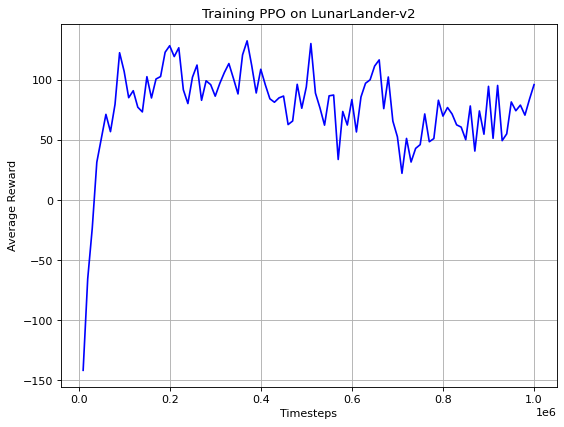

In [ ]:
# plot training curve

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(timestep_list, ave_reward_list, color="blue")
plt.title("Training PPO on LunarLander-v2")
plt.xlabel("Timesteps")
plt.ylabel("Average Reward")
plt.grid(True)
plt.show()

**Test - get weights**

In [ ]:
# get weights 

get_weights_path = '/content/drive/MyDrive/ECE239AS Group Project/code/ppo_trained_{}.pth'.format(parameter_name)

**Test - test many episodes & get avg reward**

In [ ]:
env = gym.make("LunarLander-v2")


# not have continuous action space
actor = nn.Sequential(nn.Linear(state_dim, 64),
                      nn.Tanh(),
                      nn.Linear(64, 64),
                      nn.Tanh(),
                      nn.Linear(64, action_dim),
                      nn.Softmax(dim=-1)
                      )

critic = nn.Sequential(nn.Linear(state_dim, 64),
                       nn.Tanh(),
                       nn.Linear(64, 64),
                       nn.Tanh(),
                       nn.Linear(64, 1)
                       )


# loading 'saved weights' and check if it's the same as above

# initialize a PPO agent
ppo_agent = PPO(actor, 
                critic,
                action_dim,
                lr_actor,
                lr_critic,
                gamma, 
                k_epochs,
                eps_clip,
                has_continuous_action_space,
                device)

#load into ppo_agent
ppo_agent.load_actor(get_weights_path)
#print(ppo_agent.actor.state_dict())

# test loop
num_test_episodes = 500
test_print_frequency = 10
reward_total = 0

for episode in range(num_test_episodes):
  state = env.reset()
  reward_episode = 0
  
  for t in range (1, max_episode_steps+1):
    action = ppo_agent.select_action(state)
    state, rewardt, done, _ = env.step(action)
    reward_episode += rewardt

    if done:
        break
  
  # clear buffer    
  ppo_agent.buffer.clear()
   
  if (episode % test_print_frequency ==0 ):
    print('Episode {}/{} \t Reward: {}'.format(episode+1, num_test_episodes, reward_episode))

  reward_total += reward_episode

env.close()
print('Average reward across {} episodes: {}'.format(num_test_episodes, reward_total/num_test_episodes))


Episode 1/500 	 Reward: 106.05717336508354
Episode 11/500 	 Reward: 49.686879214124275
Episode 21/500 	 Reward: 12.654468825055588
Episode 31/500 	 Reward: 264.32426693320895
Episode 41/500 	 Reward: 263.8156227699726
Episode 51/500 	 Reward: 98.42105799274472
Episode 61/500 	 Reward: 250.75030660397215
Episode 71/500 	 Reward: 53.354586204056545
Episode 81/500 	 Reward: 88.7980371558396
Episode 91/500 	 Reward: 311.148275326569
Episode 101/500 	 Reward: -46.98610212087566
Episode 111/500 	 Reward: 286.08575811247584
Episode 121/500 	 Reward: 283.544100823659
Episode 131/500 	 Reward: -26.186755162918345
Episode 141/500 	 Reward: 274.11466867093304
Episode 151/500 	 Reward: 58.10080208624322
Episode 161/500 	 Reward: 272.45875009828364
Episode 171/500 	 Reward: 178.61102870710437
Episode 181/500 	 Reward: 52.54355798065444
Episode 191/500 	 Reward: 69.81851901262536
Episode 201/500 	 Reward: 48.919444581517354
Episode 211/500 	 Reward: 27.225831647990518
Episode 221/500 	 Reward: 242.5

**Test - test 1 episode & save into gif (or optional render right here too)**

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
from IPython import display as ipythondisplay
from PIL import Image
import glob

In [ ]:
import os.path
from os import path

if path.exists('/content/drive/MyDrive/ECE239AS Group Project/code/gif_segments_{}'.format(parameter_name)) == False:
  os.mkdir('/content/drive/MyDrive/ECE239AS Group Project/code/gif_segments_{}'.format(parameter_name))


Total reward at time step 1: -1.7980901441301274
Total reward at time step 2: -3.853931105541929
Total reward at time step 3: -6.545477111569365
Total reward at time step 4: -7.335747935607254
Total reward at time step 5: -10.207634463819824
Total reward at time step 6: -11.124065157797268
Total reward at time step 7: -12.103416396489243
Total reward at time step 8: -14.872866884383217
Total reward at time step 9: -15.82959273745634
Total reward at time step 10: -16.786352955856316
Total reward at time step 11: -17.771936859994
Total reward at time step 12: -18.627068679507275
Total reward at time step 13: -19.164472978051904
Total reward at time step 14: -19.65794666030554
Total reward at time step 15: -19.98298719811406
Total reward at time step 16: -20.01376748723324
Total reward at time step 17: -21.145825328251092
Total reward at time step 18: -21.1870217780844
Total reward at time step 19: -22.128466483051213
Total reward at time step 20: -22.641297863639906
Total reward at time 

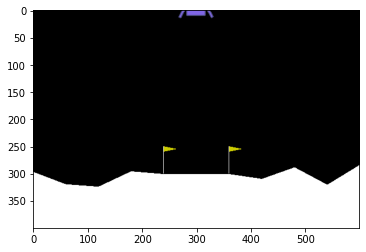

In [ ]:
actor = nn.Sequential(nn.Linear(state_dim, 64),
                      nn.Tanh(),
                      nn.Linear(64, 64),
                      nn.Tanh(),
                      nn.Linear(64, action_dim),
                      nn.Softmax(dim=-1)
                      )

critic = nn.Sequential(nn.Linear(state_dim, 64),
                       nn.Tanh(),
                       nn.Linear(64, 64),
                       nn.Tanh(),
                       nn.Linear(64, 1)
                       )


# initialize a PPO agent
ppo_agent = PPO(actor, 
                critic,
                action_dim,
                lr_actor,
                lr_critic,
                gamma, 
                k_epochs,
                eps_clip,
                has_continuous_action_space,
                device)

#load into ppo_agent
ppo_agent.load_actor(get_weights_path)


render_here = False # set to true if you want to see the choppy images on colab

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

env = gym.make("LunarLander-v2")
state = env.reset()
reward_episode = 0
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

# this is for gif-making 
save_gif_path = '/content/drive/MyDrive/ECE239AS Group Project/code/gif_segments_{}/'.format(parameter_name)

# play out 1 episode
for i in range(max_episode_steps):
  action = ppo_agent.select_action(state)
  obs, reward, done, info = env.step(action)
  reward_episode += reward
  print("Total reward at time step {}: {}".format(i+1, reward_episode))
  screen = env.render(mode='rgb_array')
  
  # save screen images for gif
  image_i = Image.fromarray(screen)
  image_i.save(save_gif_path + str(i).zfill(4) + '.jpg')

  # render here in colab 
  if render_here:
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

  if done:
    break

if render_here:    
  ipythondisplay.clear_output(wait=True)
  display.stop()

env.close()
print("Breaked at time step {}".format(i+1))

In [ ]:
# turn saved jpegs into gif 
save_gif_path = '/content/drive/MyDrive/ECE239AS Group Project/code/gif_segments_{}/'.format(parameter_name)

fp_in = "/content/drive/MyDrive/ECE239AS Group Project/code/gif_segments_{}/*".format(parameter_name)

fp_out = save_gif_path = '/content/drive/MyDrive/ECE239AS Group Project/code/gif_segments_{}/image.gif'.format(parameter_name)


img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, 
         duration=200, loop=0)

In [ ]:
i

71